In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# For ARIMA
from statsmodels.tsa.arima.model import ARIMA

# For Prophet
from prophet import Prophet

# For XGBoost
import xgboost as xgb

Step 1: Data Loading & Initial Processing

In [10]:
# Load the dataset
try:
    df = pd.read_csv("power_consumpxTime.csv")
except FileNotFoundError:
    print("Error: The file 'power_consumpxTime.csv' was not found. Please make sure it's in the correct directory.")
    exit()

# Combine 'Date' and 'Time' columns and convert to datetime
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('datetime', inplace=True)

# Remove the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

C:\Users\PMLS\AppData\Local\Temp\ipykernel_2360\3979543222.py:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


Step 2:Cleaning and Resampled to a daily frequency

In [11]:
# The target variable for forecasting is 'Global_active_power'
# Handle missing values by replacing '?' with NaN and then converting to numeric
df.replace('?', np.nan, inplace=True)
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'])

# Since the data is at a minute-level, it's very large. Let's resample it to a daily frequency
# We'll use the mean of 'Global_active_power' for each day
df_daily = df['Global_active_power'].resample('D').mean().to_frame()

In [12]:
# Fill any remaining missing values that might have appeared after resampling
df_daily.fillna(method='ffill', inplace=True)
df_daily.dropna(inplace=True) # Remove any remaining NaN at the beginning

print("✅ Data has been successfully loaded, cleaned, and resampled to a daily frequency.")
print(df_daily.head())
print("\n")

✅ Data has been successfully loaded, cleaned, and resampled to a daily frequency.
            Global_active_power
datetime                       
2006-12-16             3.053475
2006-12-17             2.354486
2006-12-18             1.530435
2006-12-19             1.157079
2006-12-20             1.545658




C:\Users\PMLS\AppData\Local\Temp\ipykernel_2360\1882198684.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_daily.fillna(method='ffill', inplace=True)


Step 3: Feature Engineering (3 new features)

In [13]:
# We create features that do not cause data leakage because they are derived from the timestamp itself,
# which is always available for future predictions.

# Feature 1: Day of the Week
df_daily['dayofweek'] = df_daily.index.dayofweek

# Feature 2: Month
df_daily['month'] = df_daily.index.month

# Feature 3: Is it a Weekend?
df_daily['is_weekend'] = (df_daily.index.dayofweek >= 5).astype(int)

print("✅ New time-based features created:")
print(df_daily.head())

✅ New time-based features created:
            Global_active_power  dayofweek  month  is_weekend
datetime                                                     
2006-12-16             3.053475          5     12           1
2006-12-17             2.354486          6     12           1
2006-12-18             1.530435          0     12           0
2006-12-19             1.157079          1     12           0
2006-12-20             1.545658          2     12           0


Step 4:  Model Comparison for Splitting & Testing

In [14]:
# Split the data into training and testing sets (chronological split)
forecast_period = 30
train_data = df_daily[:-forecast_period]
test_data = df_daily[-forecast_period:]

print(f"Total data points: {df_daily.shape[0]}")
print(f"Training data points: {train_data.shape[0]}")
print(f"Testing data points: {test_data.shape[0]}")

# Store forecast results for comparison
results = pd.DataFrame(test_data)
all_forecasts = pd.DataFrame(index=test_data.index)

Total data points: 729
Training data points: 699
Testing data points: 30


Step 5: Model Training (one-by-one)

Model 1: ARIMA (AutoRegressive Integrated Moving Average)

In [15]:
# ----------------- Model 1: ARIMA -----------------
print("\n--- Training ARIMA Model ---")
try:
    arima_model = ARIMA(train_data['Global_active_power'], order=(1, 1, 1))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=forecast_period)
    all_forecasts['ARIMA'] = arima_forecast
    print("✅ ARIMA model trained and forecasted.")
except Exception as e:
    print(f"ARIMA model failed: {e}")
    all_forecasts['ARIMA'] = np.nan


--- Training ARIMA Model ---
✅ ARIMA model trained and forecasted.


Model 2: Prophet

In [16]:
# ----------------- Model 2: Prophet -----------------
print("\n--- Training Prophet Model ---")
prophet_df = train_data.reset_index().rename(columns={'datetime': 'ds', 'Global_active_power': 'y'})
m = Prophet()
m.fit(prophet_df)

# Create a future dataframe for forecasting
future = m.make_future_dataframe(periods=forecast_period)
prophet_forecast = m.predict(future)

# Store the Prophet forecast
all_forecasts['Prophet'] = prophet_forecast['yhat'][-forecast_period:].values
print("✅ Prophet model trained and forecasted.")


--- Training Prophet Model ---


12:48:02 - cmdstanpy - INFO - Chain [1] start processing
12:48:03 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet model trained and forecasted.


Model 3: XGBoost

In [ ]:
# ----------------- Model 3: XGBoost -----------------
print("\n--- Training XGBoost Model ---")
# Separate features and target
X_train = train_data.drop(columns='Global_active_power')
y_train = train_data['Global_active_power']
X_test = test_data.drop(columns='Global_active_power')
y_test = test_data['Global_active_power']

# Initialize and train the XGBoost Regressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xg_reg.fit(X_train, y_train)

# Predict on the test data
xgboost_forecast = xg_reg.predict(X_test)
all_forecasts['XGBoost'] = xgboost_forecast
print("✅ XGBoost model trained and forecasted.")


--- Training XGBoost Model ---
✅ XGBoost model trained and forecasted.


Step6:Model Evaluation for Comparision

In [22]:
# ----------------- Step 4: Model Evaluation -----------------
print("\n--- Model Performance Comparison ---")
results = pd.DataFrame(index=test_data.index)
results['Actual'] = test_data['Global_active_power']

metrics = {}

for model_name in all_forecasts.columns:
    if model_name in ['ARIMA', 'Prophet', 'XGBoost']:
        mae = mean_absolute_error(results['Actual'], all_forecasts[model_name])
        rmse = math.sqrt(mean_squared_error(results['Actual'], all_forecasts[model_name]))
        metrics[model_name] = {'MAE': mae, 'RMSE': rmse}

metrics_df = pd.DataFrame(metrics).T
print(metrics_df.round(2))


--- Model Performance Comparison ---
          MAE  RMSE
ARIMA    0.28  0.42
Prophet  0.60  0.68
XGBoost  0.41  0.49


Step7: All Models Visualizations


--- Visualization of Forecasts vs. Actuals ---


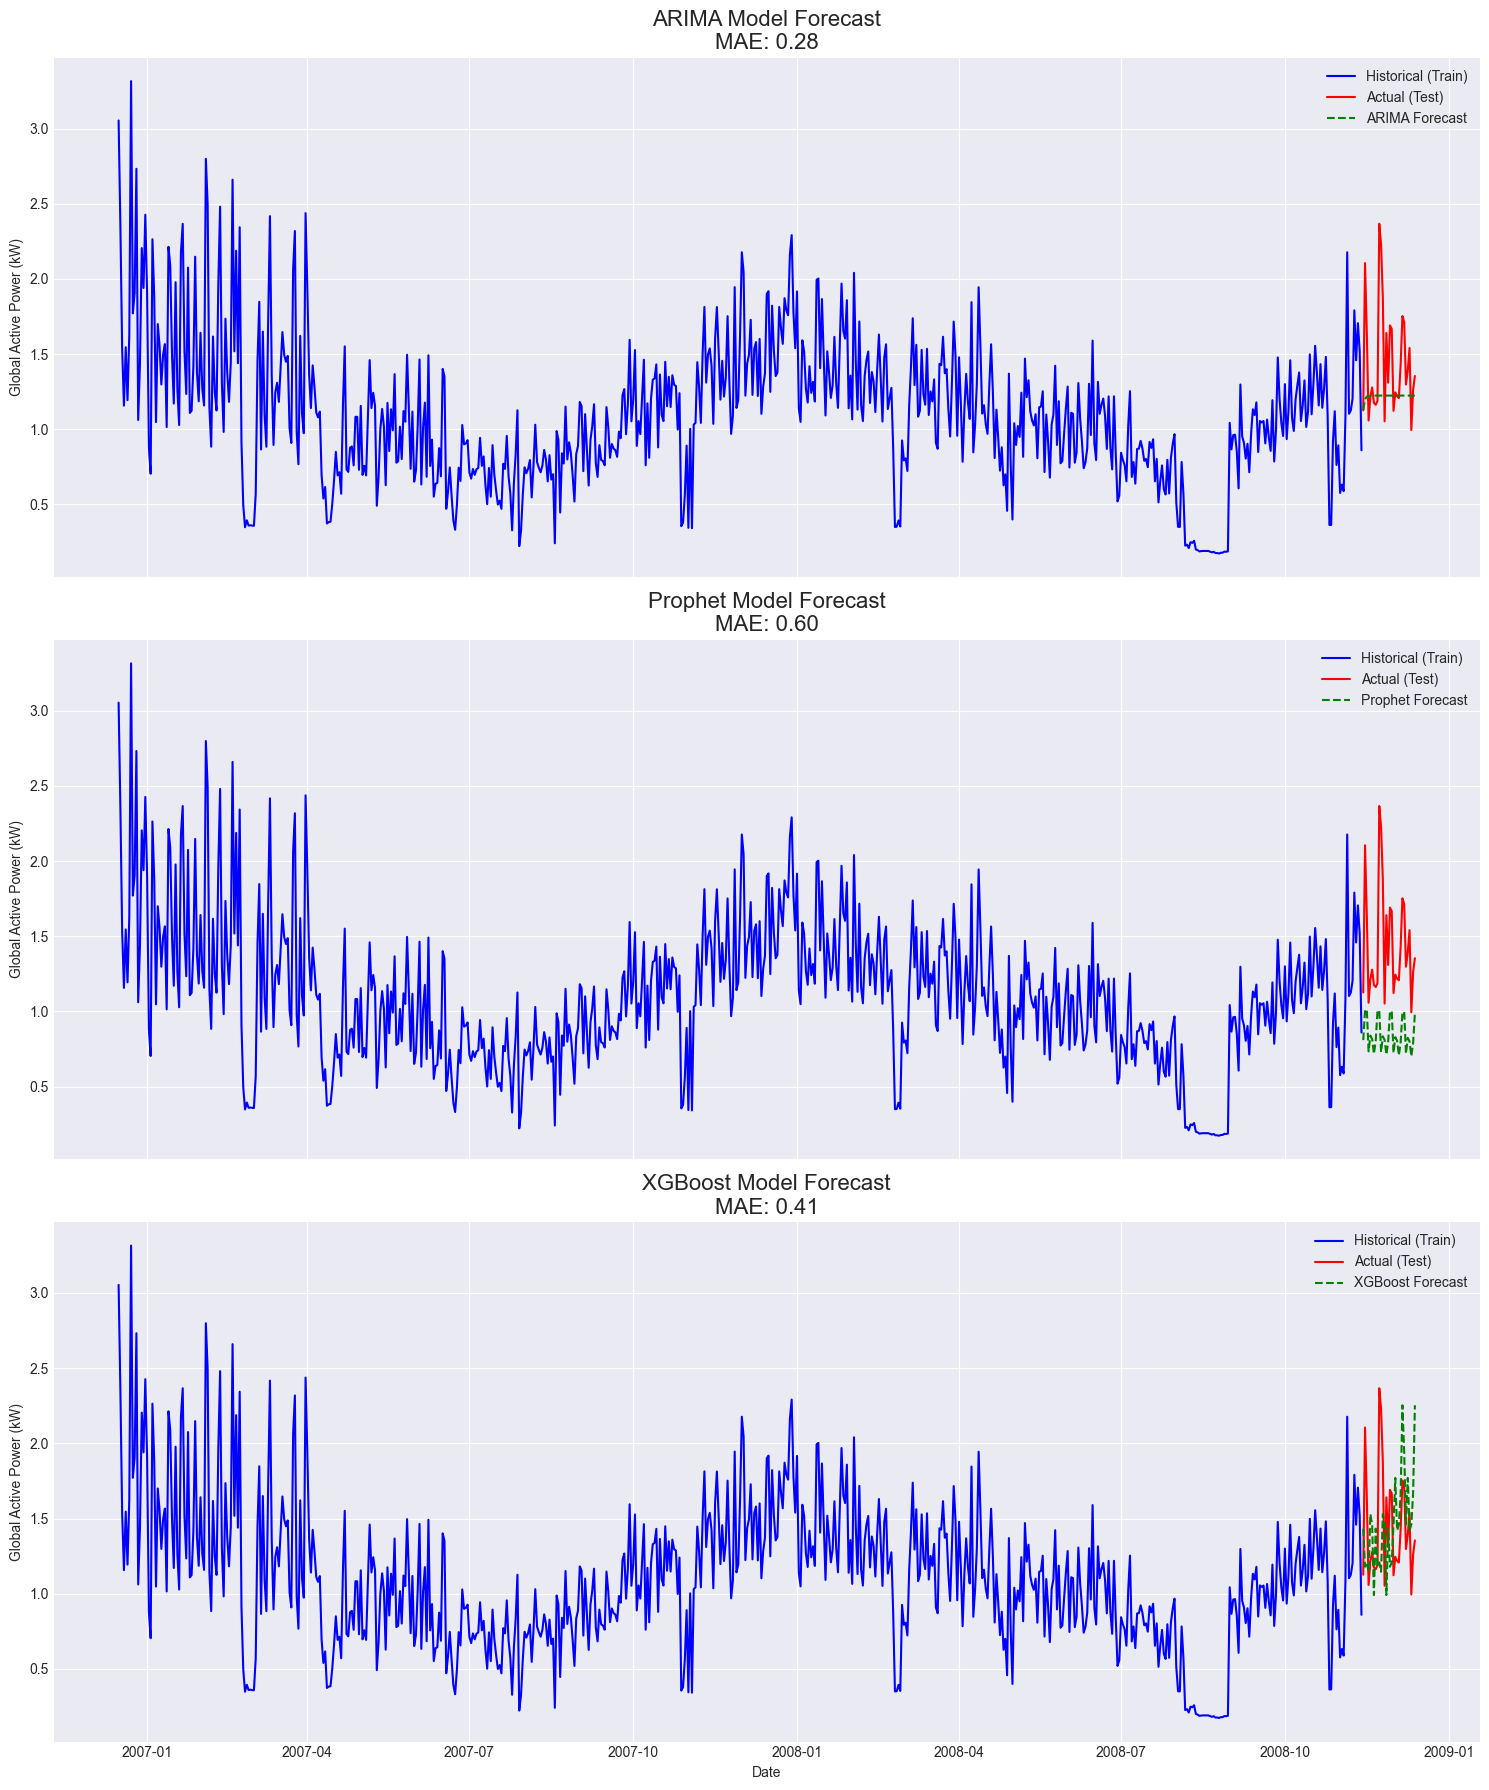

In [25]:
# ----------------- Step 5: Visualization -----------------
print("\n--- Visualization of Forecasts vs. Actuals ---")
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(3, 1, figsize=(15, 18), sharex=True)

# ARIMA Plot
axes[0].plot(train_data.index, train_data['Global_active_power'], label='Historical (Train)', color='blue')
axes[0].plot(test_data.index, test_data['Global_active_power'], label='Actual (Test)', color='red')
if 'ARIMA' in all_forecasts.columns:
    axes[0].plot(all_forecasts.index, all_forecasts['ARIMA'], label='ARIMA Forecast', color='green', linestyle='--')
axes[0].set_title(f'ARIMA Model Forecast\nMAE: {metrics_df.loc["ARIMA", "MAE"]:.2f}', fontsize=16)
axes[0].legend()
axes[0].set_ylabel('Global Active Power (kW)')

# Prophet Plot
axes[1].plot(train_data.index, train_data['Global_active_power'], label='Historical (Train)', color='blue')
axes[1].plot(test_data.index, test_data['Global_active_power'], label='Actual (Test)', color='red')
axes[1].plot(all_forecasts.index, all_forecasts['Prophet'], label='Prophet Forecast', color='green', linestyle='--')
axes[1].set_title(f'Prophet Model Forecast\nMAE: {metrics_df.loc["Prophet", "MAE"]:.2f}', fontsize=16)
axes[1].legend()
axes[1].set_ylabel('Global Active Power (kW)')

# XGBoost Plot
axes[2].plot(train_data.index, train_data['Global_active_power'], label='Historical (Train)', color='blue')
axes[2].plot(test_data.index, test_data['Global_active_power'], label='Actual (Test)', color='red')
axes[2].plot(all_forecasts.index, all_forecasts['XGBoost'], label='XGBoost Forecast', color='green', linestyle='--')
axes[2].set_title(f'XGBoost Model Forecast\nMAE: {metrics_df.loc["XGBoost", "MAE"]:.2f}', fontsize=16)
axes[2].legend()
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Global Active Power (kW)')

plt.tight_layout()
plt.show()

Step 8: Choosing Best Model for Analysis

In [26]:
# ----------------- Final Summary -----------------
print("\n--- Best Model Analysis ---")
best_model = metrics_df['MAE'].idxmin()
print(f"Based on Mean Absolute Error (MAE), the best model is: {best_model} with a MAE of {metrics_df.loc[best_model, 'MAE']:.2f}")


--- Best Model Analysis ---
Based on Mean Absolute Error (MAE), the best model is: ARIMA with a MAE of 0.28


Step 9: Final Model Performance Summary 

In [28]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import math

# Assuming 'test_data' and 'all_forecasts' DataFrames are available from the previous run.
# 'test_data' is your actual values and 'all_forecasts' contains the predictions from each model.

print("--- Final Model Performance Summary ---")

# Create a dictionary to store the evaluation metrics
comparison_metrics = {}

# Get the actual values from the test data
y_true = test_data['Global_active_power']

# Loop through each model's forecasts to calculate metrics
for model_name in all_forecasts.columns:
    if model_name in ['ARIMA', 'Prophet', 'XGBoost']:
        y_pred = all_forecasts[model_name]

        # Calculate the metrics
        mae = mean_absolute_error(y_true, y_pred)
        rmse = math.sqrt(mean_squared_error(y_true, y_pred))

        # R-squared can sometimes be negative for a poor model, so handle that
        r2 = r2_score(y_true, y_pred)
        r2_value = max(0, r2)

        # Store metrics in the dictionary
        comparison_metrics[model_name] = {
            'MAE': mae,
            'RMSE': rmse,
            'R-squared': r2_value
        }

# Convert the dictionary to a DataFrame for clean display
metrics_df = pd.DataFrame(comparison_metrics).T

# Round the values for better readability
metrics_df = metrics_df.round(4)

print(metrics_df)

print("\n")
print("--- Analysis of Metrics ---")
best_model = metrics_df['MAE'].idxmin()
print(f"Based on all metrics, the best-performing model is: {best_model}")

--- Final Model Performance Summary ---
            MAE    RMSE  R-squared
ARIMA    0.2805  0.4158        0.0
Prophet  0.5997  0.6758        0.0
XGBoost  0.4053  0.4939        0.0


--- Analysis of Metrics ---
Based on all metrics, the best-performing model is: ARIMA


Step 10: Exporting all Features into 1 Csv file

In [31]:
import pandas as pd
import numpy as np

# Load the original dataset
df = pd.read_csv("power_consumpxTime.csv")

# Combine 'Date' and 'Time' columns into a single 'datetime' column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df.set_index('datetime', inplace=True)

# Drop the original 'Date' and 'Time' columns as they are no longer needed
df.drop(columns=['Date', 'Time'], inplace=True)

# Convert the target variable to a numeric format
df.replace('?', np.nan, inplace=True)
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'])

# Fill missing values directly in the original minute-level data
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

# Engineer new time-based features from the datetime index
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

# Reset the index so 'datetime' becomes a regular column again before saving
df.reset_index(inplace=True)

# Save the processed DataFrame to a new CSV file
# Note: This file will be very large since it contains a data point for every minute.
df.to_csv("processed_power_data_with_time.csv", index=False)

print("✅ 'processed_power_data_with_time.csv' file has been successfully created.")
print("It contains data for every minute, along with the engineered features.")
print("\nFirst 5 rows of the new file:")
print(df.head())

C:\Users\PMLS\AppData\Local\Temp\ipykernel_2360\702913398.py:8: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
C:\Users\PMLS\AppData\Local\Temp\ipykernel_2360\702913398.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


✅ 'processed_power_data_with_time.csv' file has been successfully created.
It contains data for every minute, along with the engineered features.

First 5 rows of the new file:
             datetime  Global_active_power Global_reactive_power Voltage  \
0 2006-12-16 17:24:00                4.216                 0.418  234.84   
1 2006-12-16 17:25:00                5.360                 0.436  233.63   
2 2006-12-16 17:26:00                5.374                 0.498  233.29   
3 2006-12-16 17:27:00                5.388                 0.502  233.74   
4 2006-12-16 17:28:00                3.666                 0.528  235.68   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  dayofweek  \
0             18.4              0              1            17.0          5   
1               23              0              1            16.0          5   
2               23              0              2            17.0          5   
3               23              0              1  